In [1]:
# Exploring Social Network Data

# Karate Club Dataset
# Simulating Data
# Characterizing Network Features
# Deliverables

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from collections import Counter
import numpy as np

import torch
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import KarateClub


from sknetwork.data import karate_club
from sknetwork.clustering import Louvain


from sklearn.cluster import KMeans

dataset = KarateClub()


In [3]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
    
def visualize_graph_labels(G, color, ColorLegend):
    
    markerSize=50
    pos=nx.spring_layout(G)

    # Color mapping
    jet = cm = plt.get_cmap('plasma')
    cNorm  = colors.Normalize(vmin=0, vmax=max(color))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)
    for label in ColorLegend:
        ax.scatter([0],[0],marker='o',color=scalarMap.to_rgba(ColorLegend[label]),label=label, s=markerSize)

    ax.scatter([0],[0],marker='o',color='w',edgecolors='none',s=markerSize+100)
    # Just fixed the color map
    nx.draw_networkx(G,pos, cmap = jet, vmin=0, vmax= max(color),node_color=color,with_labels=True,ax=ax)

    # Setting it to how it was looking before.                                                                                                              
    plt.axis('off')
    f.set_facecolor('w')

    plt.legend()

    f.tight_layout()
    plt.show()
    
def visualize_graph_labels_size(G, color, ColorLegend,node_size):
    
    pos=nx.spring_layout(G)

    markerSize=50

    # Color mapping
    jet = cm = plt.get_cmap('plasma')
    cNorm  = colors.Normalize(vmin=0, vmax=max(color))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)
    for label in ColorLegend:
        ax.scatter([0],[0],marker='o',color=scalarMap.to_rgba(ColorLegend[label]),label=label, s=markerSize)

    ax.scatter([0],[0],marker='o',color='w',edgecolors='none',s=markerSize+100)
    # Just fixed the color map
    nx.draw_networkx(G,pos, cmap = jet, vmin=0, vmax= max(color),
                     node_color=color,with_labels=True,
                     node_size=node_size, ax=ax)

    # Setting it to how it was looking before.                                                                                                              
    plt.axis('off')
    f.set_facecolor('w')

    plt.legend()

    f.tight_layout()
    plt.show()
    

Dataset properties
Dataset: KarateClub()
Number of graphs in the dataset: 1
Number of features: 34
Number of classes: 4
Graph properties
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


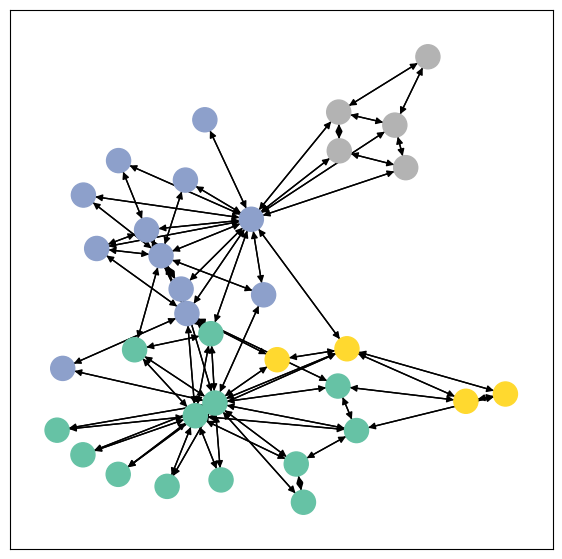

In [4]:
print('Dataset properties')
print('==============================================================')
print(f'Dataset: {dataset}') #This prints the name of the dataset
print(f'Number of graphs in the dataset: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Number of features each node in the dataset has
print(f'Number of classes: {dataset.num_classes}') #Number of classes that a node can be classified into


#Since we have one graph in the dataset, we will select the graph and explore it's properties

data = dataset[0]
print('Graph properties')
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}') #Number of nodes in the graph
print(f'Number of edges: {data.num_edges}') #Number of edges in the graph
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average number of nodes in the graph
print(f'Contains isolated nodes: {data.has_isolated_nodes()}') #Does the graph contains nodes that are not connected
print(f'Contains self-loops: {data.has_self_loops()}') #Does the graph contains nodes that are linked to themselves
print(f'Is undirected: {data.is_undirected()}') #Is the graph an undirected graph

sendNodeList=data.edge_index.tolist()[0]
receiveNodeList=data.edge_index.tolist()[1]
cDict=Counter(sendNodeList)


G = to_networkx(data, to_undirected=False)
visualize_graph(G, color=data.y)

In [5]:
# simulating company social network

# each node is an employee. each edge is a connection between them
# there are multiple types of employees:
# CEO: connected to (nearly) all employees
# Manager: connected to all employees in cluster
# Broadcaster: part of cluster, but connected to others outside cluster
# Loner: Much fewer connections than average
# Relay: connected to ONLY 2 employees

def generate_graph(nNodes=25,nClusters=3,nRandConnections=10, nCEOs=2,
                   nManagersPerCluster=2,nBroadcastersPerCluster=2,nLonersPerCluster=1,
                   nRelays=4, clusterWeight=0.75):

    # graph params
    nodeList = [int(i) for i in np.arange(nNodes)]

    # inds of nodes for each cluster
    clusterSets = [int(i) for i in np.linspace(0,nNodes,nClusters+1)]
    nPerCluster=clusterSets[1]-clusterSets[0]

    # how likely individuals are to connect within cluster
    clusterWeight=.75

    # simulate social roles
    baselineSocial=0.5

    managerSocial=.3
    lonerSocial=-1
    broadcasterSocial=1


    # initialize everyone as normal employee with normal social weight
    socialDict = {'CEO':0,'Manager':1,'Broadcaster':2,'Relay':3,'Loner':4,'Employee':5}

    # social probability for each node
    socialIndex = [socialDict['Employee']]*nNodes

    # index of social role 0=CEO, 1=Manager, 2=Broadcaster, 3=Relay, 4=loner,5=employee
    nodeSocial = [baselineSocial for i in nodeList]

    # go through each cluster and assign roles
    for i in range(len(clusterSets[:-1])):
        thisClusterSet=np.arange(clusterSets[i],clusterSets[i+1])
        cManagerInds=np.random.choice(thisClusterSet,nManagersPerCluster,replace=False)
        for m in cManagerInds:
            nodeSocial[m]=managerSocial
            socialIndex[m]=socialDict['Manager']

        unassigned=np.setdiff1d(thisClusterSet,cManagerInds)
        lonerInds=np.random.choice(unassigned,nLonersPerCluster,replace=False)

        for lo in lonerInds:
            nodeSocial[lo]=lonerSocial
            socialIndex[lo]=socialDict['Loner']

        unassigned=np.setdiff1d(thisClusterSet,np.concatenate([lonerInds,cManagerInds]))
        broadcasterInds=np.random.choice(unassigned,nBroadcastersPerCluster,replace=False)

        for bi in broadcasterInds:
            nodeSocial[bi]=broadcasterSocial
            socialIndex[bi]=socialDict['Broadcaster']


    # initialize graph with clusters so each node is only connected to nodes within cluster
    edge_list=[]
    for i in range(len(clusterSets[:-1])):
        thisClusterSet=np.arange(clusterSets[i],clusterSets[i+1])
        for c in range(nPerCluster):
            thisInd=clusterSets[i]+c

            nodeConnections=np.setdiff1d(thisClusterSet,thisInd)

            for n in nodeConnections:
                # add social probability, avg of cluster weight, sender, and receiver 
                socialProb=np.mean([clusterWeight,nodeSocial[thisInd],nodeSocial[n]])
                
                # if its a manager, they are definitely connected
                if socialIndex[thisInd] == socialDict['Manager']:
                    edge_list.append([thisInd,n])
                    
                elif socialProb > np.random.rand():
                    edge_list.append([thisInd,n])
                    


    # broadcasters connect BETWEEN clusters
    broadcasterInds=[e for e,i in enumerate(socialIndex) if i==socialDict['Broadcaster']]

    clusterSetArray=np.array(clusterSets)

    for bi in broadcasterInds:
        # find cluster that broadcaster belongs to
        clusterInd=clusterSetArray[clusterSetArray <= bi].argmax()  
        thisClusterSet=np.arange(clusterSets[clusterInd],clusterSets[clusterInd+1])

        # all members of other clusters
        potentialConnections = np.setdiff1d(nodeList,thisClusterSet)

        for pc in potentialConnections:
            socialProb=np.mean([clusterWeight,nodeSocial[bi],nodeSocial[pc]])
            if socialProb > np.random.rand():
                edge_list.append([thisInd,n])


    # add CEOs who are connected to everybody
    normieIndex=[i for i, e in enumerate(socialIndex) if e == socialDict['Employee']]
    ceoInds=sorted(np.random.choice(normieIndex,nCEOs,replace=False))
    for c in ceoInds:
        nodeSocial[c]=100
        socialIndex[c]=socialDict['CEO']
        for oth in np.setdiff1d(range(nNodes-1),c):
            edge_list.append([c,oth])


    # add socially weighted randomness
    randInds=np.random.choice(nodeList,nRandConnections,replace=False)
    randReceive = [np.random.choice(np.setdiff1d(edge_list,i)) for i in randInds]

    # apply weights and see what survives
    survivingRandInds=[]
    survivingRandReceive=[]
    for i in range(len(randInds)):
        socialProb= np.mean([nodeSocial[randInds[i]],nodeSocial[randReceive[i]]])
        if socialProb > np.random.rand():
            survivingRandInds.append(randInds[i])
            survivingRandReceive.append(randReceive[i])


    rand_edges = [[a,b] for a,b in zip(survivingRandInds,survivingRandReceive)]
    edge_list=edge_list+rand_edges


    # remove duplicates from edge_list (either direction)
    cleaned_edge_list=[]
    for elem in edge_list:
        if elem not in cleaned_edge_list and [elem[1],elem[0]] not in cleaned_edge_list:
            cleaned_edge_list.append(elem)

    edge_list=cleaned_edge_list


    # assign relay roles
    # relays ONLY connect to two nodes

    normieIndex=[i for i, e in enumerate(socialIndex) if e == socialDict['Employee']]
    relayInds=sorted(np.random.choice(normieIndex,nRelays,replace=False))

    for r in relayInds:
        socialIndex[r]=socialDict['Relay']

    # repeat this in case too many edges get clipped
    for rep in range(3):

        for i in range(len(relayInds)):
            # find inds of any connections this node has in edge_list 
            thisNodeRelayInds=[c for c, e in enumerate(edge_list) if e[0] == relayInds[i] or e[1] == relayInds[i]]

            if len(thisNodeRelayInds)>2:
                if rep==1:
                    break
                # just pick two connections
                onlyThese=np.random.choice(thisNodeRelayInds,2,replace=False)
                removeThese=np.setdiff1d(thisNodeRelayInds,onlyThese).tolist()
                
                # remove all other connections
                for i in sorted(removeThese, reverse=True):
                    del edge_list[i]

            elif len(thisNodeRelayInds)==1:
                # just add 1 random edge but not to another relay
                otherNodes = np.setdiff1d(nodeList,relayInds)
                thisNode=np.random.choice(otherNodes)
                edge_list.append([relayInds[i],thisNode])


            elif len(thisNodeRelayInds)==0:
                # add 2 edges but don't connect to another relay
                otherNodes = np.setdiff1d(nodeList,relayInds)
                theseNodes=np.random.choice(otherNodes,2,replace=False)
                for t in theseNodes:
                    edge_list.append([relayInds[i],t])

    # put it all in a graph
    G=nx.Graph()
    for i in nodeList:
        G.add_node(i)
    G.add_edges_from(edge_list)
    
    return G, socialIndex, socialDict, edge_list
  

In [6]:
# generate a graph
nNodes=100
nClusters=4
nodeList = [int(i) for i in np.arange(nNodes)]

nRandConnections=100
nManagersPerCluster=1
nBroadcastersPerCluster=5
nLonersPerCluster=2
nRelays=10

G, socialIndex,socialDict, edge_list=generate_graph(nNodes=nNodes,nClusters=nClusters,
                                                    nRandConnections=nRandConnections, nCEOs=1,
                                                    nManagersPerCluster=nManagersPerCluster,nBroadcastersPerCluster=nBroadcastersPerCluster,
                                                    nLonersPerCluster=nLonersPerCluster,nRelays=nRelays)

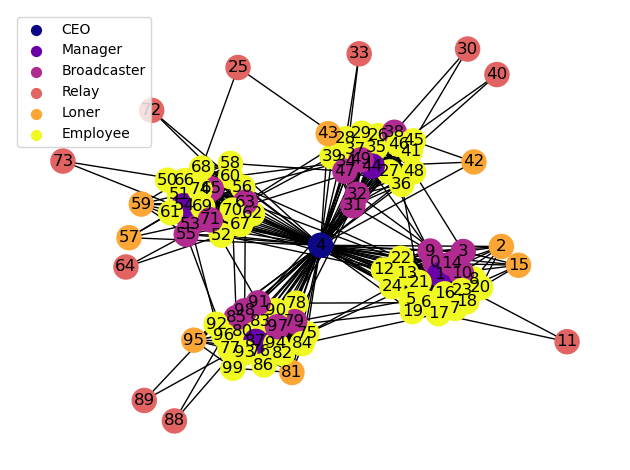

In [7]:
ColorLegend = {'CEO': 0, 'Manager':1,'Broadcaster': 2,'Relay': 3,'Loner': 4,'Employee':5}
visualize_graph_labels(G,socialIndex,ColorLegend)

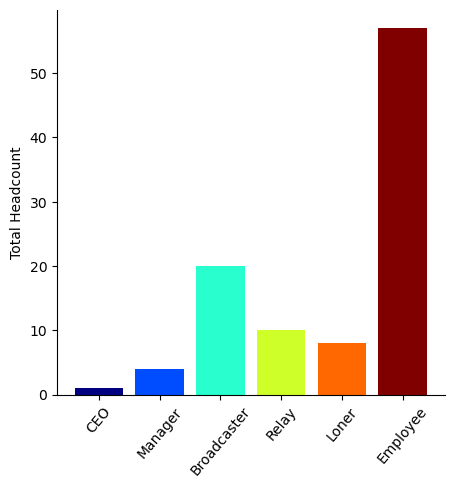

In [8]:
# check if role counts are right

socialCounter=Counter(socialIndex)

WIDTH_SIZE=5;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))

jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=max(socialIndex))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(socialDict.keys())):
    axs.bar(i,socialCounter[i],color=scalarMap.to_rgba(i))

axs.set_ylabel('Total Headcount')
axs.set_xticks(list(socialDict.values()))
axs.set_xticklabels(list(socialDict.keys()),rotation = 50)
axs.spines[['right', 'top']].set_visible(False)

In [10]:
# get network stats

# count all connections for each node
flat_list = [item for sublist in edge_list for item in sublist]
cDict=Counter(flat_list)

# print(cDict)

# look at connections of each node
# print(list(G.adj[25]))

shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

# max number of nodes to reach other nodes
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())

print("Max distance between nodes={}".format(diameter))

# average distance to reach other nodes
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
print("Avg distance between nodes={}".format(np.mean(average_path_lengths)))

# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()


Gdensity= nx.density(G)
nConnectedGraphs=nx.number_connected_components(G)

print("Graph density={}".format(Gdensity))
print("N connected Graphs={}".format(nConnectedGraphs))

degree_centrality = nx.centrality.degree_centrality(
G
)  
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True));

Max distance between nodes=4
Avg distance between nodes=1.9582
Graph density=0.1795959595959596
N connected Graphs=1


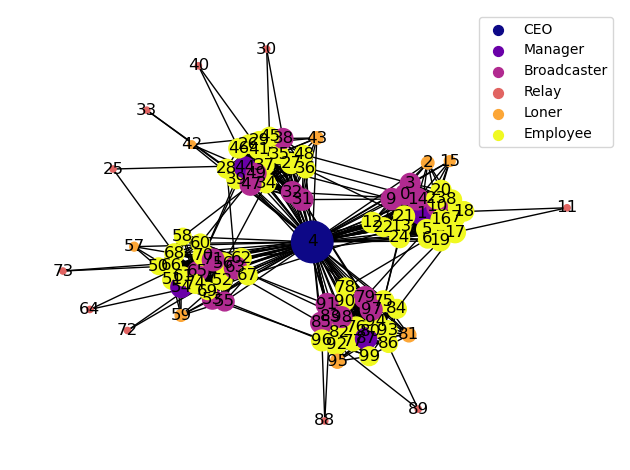

In [11]:
# plot graph with size representing degree_centrality
node_size = [v * 1000 for v in degree_centrality.values()]

visualize_graph_labels_size(G,socialIndex,ColorLegend,node_size)

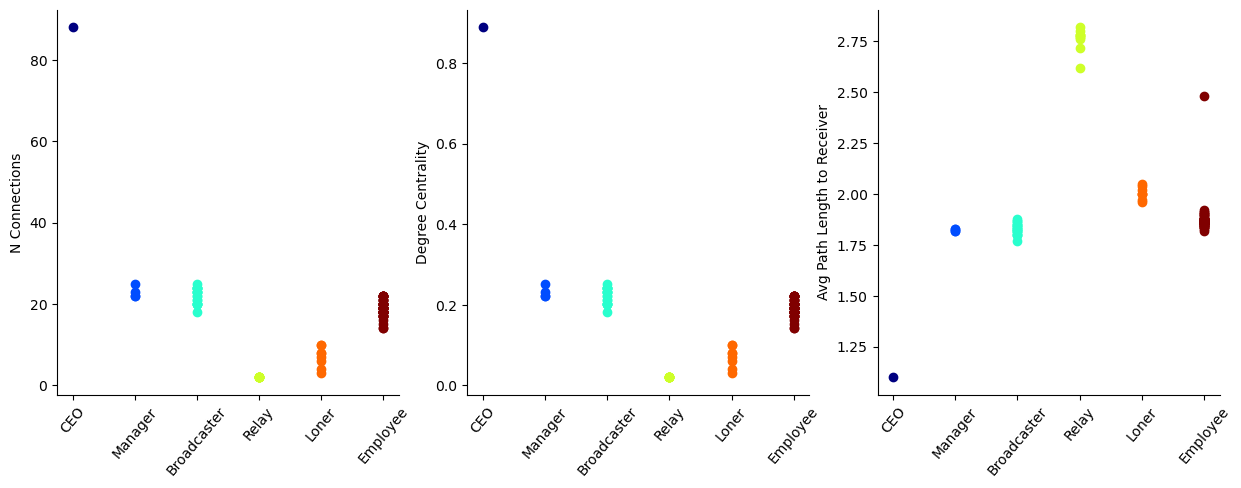

In [12]:
# validate simulation with network metrics
avg_path_length_dict = {i: average_path_lengths[i] for i in nodeList}

WIDTH_SIZE=15;
HEIGHT_SIZE=5;


fig, axs = plt.subplots(1,3,figsize=(WIDTH_SIZE,HEIGHT_SIZE))

jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=max(socialIndex))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for pli in range(3):
    if pli == 0:
        thisDict=cDict
        metricLabel='N Connections'
        
    elif pli == 1:
        thisDict=degree_centrality
        metricLabel='Degree Centrality'
    elif pli ==2:
        thisDict=avg_path_length_dict
        metricLabel='Avg Path Length to Receiver'
        
    for sInd,sLabel in enumerate(ColorLegend):
        #print(sInd,sLabel)
        thisSI=[i for i, e in enumerate(socialIndex) if e == sInd]

        for i in thisSI:
            axs[pli].scatter(sInd,thisDict[i],marker='o',color=scalarMap.to_rgba(sInd))

    axs[pli].set_ylabel(metricLabel)
    axs[pli].set_xticks(list(ColorLegend.values()))
    axs[pli].set_xticklabels(list(ColorLegend.keys()),rotation = 50)
    axs[pli].spines[['right', 'top']].set_visible(False)

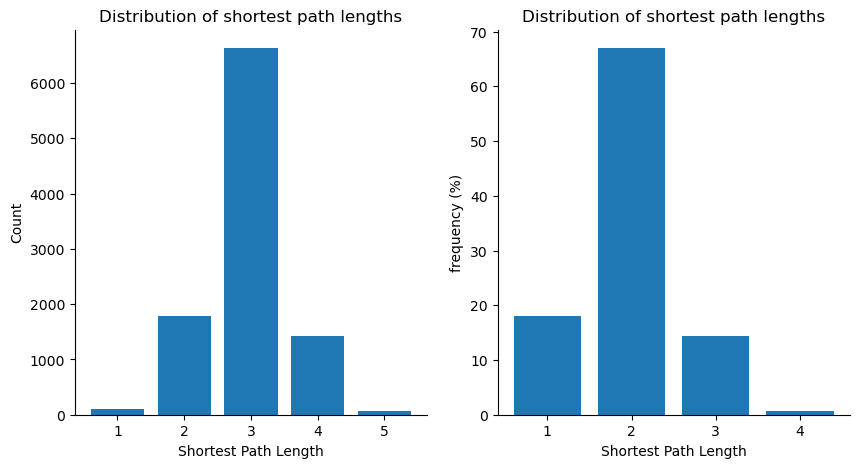

In [13]:
# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
WIDTH_SIZE=10;
HEIGHT_SIZE=5;


fig, axs = plt.subplots(1,2,figsize=(WIDTH_SIZE,HEIGHT_SIZE))

for i in range(2):
    if i==0:
        thisVar=path_lengths
        thisLabel='Count'
        thisXTick=np.arange(1, diameter+2)
    if i==1:
        thisVar=freq_percent
        thisLabel='frequency (%)'
        thisXTick=np.arange(1, diameter + 1)
        
    axs[i].bar(thisXTick, height=thisVar)
    
    axs[i].set_title(
        "Distribution of shortest path lengths", loc="center")
    axs[i].set_xlabel("Shortest Path Length")
    axs[i].set_ylabel(thisLabel)
    axs[i].spines[['right', 'top']].set_visible(False)

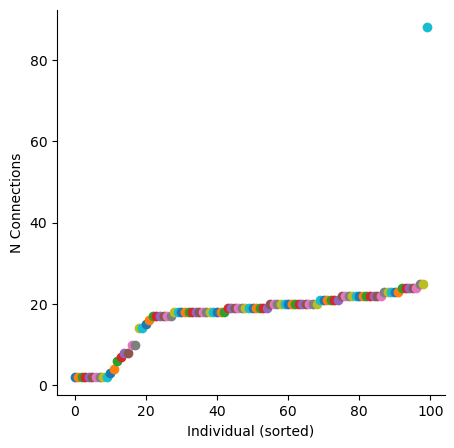

In [14]:
# plot each employee's connection count
WIDTH_SIZE=5;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))

cInds=list(cDict.keys())

keyList=list(cDict.keys())
valList=list(cDict.values())
sortedValList=np.sort(valList)


for i in nodeList:
    plt.scatter(i, sortedValList[i])
    
    

axs.set_ylabel('N Connections')
axs.set_xlabel('Individual (sorted)')

axs.spines[['right', 'top']].set_visible(False)

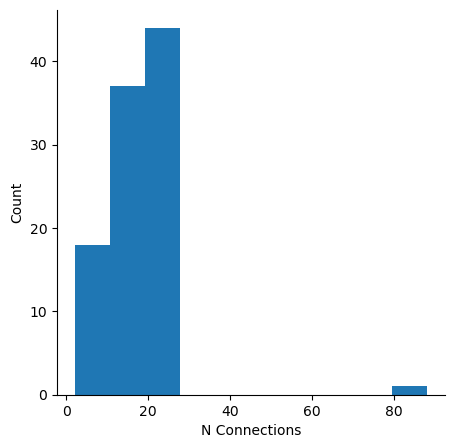

In [16]:
# plot histogram of connections

WIDTH_SIZE=5;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))


plt.hist(valList)
axs.set_ylabel('Count')
axs.set_xlabel('N Connections')

axs.spines[['right', 'top']].set_visible(False)

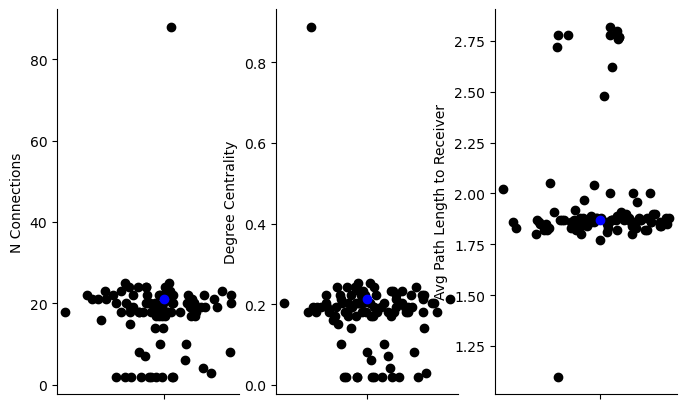

In [17]:
# tell me about a given employee

employeeInd=10
otherNodes=np.setdiff1d(nodeList,employeeInd)

WIDTH_SIZE=8;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,3,figsize=(WIDTH_SIZE,HEIGHT_SIZE))

jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=max(socialIndex))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

def rand_jitter(arr):
    stdev = .01;
    return 0 + np.random.randn(len(arr)) * stdev


for pli in range(3):
    if pli == 0:
        thisDict=cDict
        metricLabel='N Connections'
        
    elif pli == 1:
        thisDict=degree_centrality
        metricLabel='Degree Centrality'
    elif pli ==2:
        thisDict=avg_path_length_dict
        metricLabel='Avg Path Length to Receiver'
        
    xJitter=rand_jitter(list(thisDict.values()))+1
    for i in otherNodes:
        axs[pli].scatter(xJitter[i],thisDict[i],marker='o',color='k')

    axs[pli].scatter(1,thisDict[employeeInd],marker='o',color='b')

    axs[pli].set_ylabel(metricLabel)
    axs[pli].set_xticks([1])
    axs[pli].set_xticklabels({})
    
    axs[pli].spines[['right', 'top']].set_visible(False)

In [19]:
# simulate different networks and compare

baselineNetworkArgs = {'nNodes':100, 'nClusters':4, 
                       'nRandConnections':100, 'nCEOs':1,
                       'nManagersPerCluster':1,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':0.75
                      }

noCEONetworkArgs = {'nNodes':100, 'nClusters':4, 
                       'nRandConnections':100, 'nCEOs':0,
                       'nManagersPerCluster':1,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':0.75
                      }

noBroadcasterNetworkArgs = {'nNodes':100, 'nClusters':4, 
                       'nRandConnections':100, 'nCEOs':1,
                       'nManagersPerCluster':1,'nBroadcastersPerCluster':0,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':0.75
                      }

noManagerNetworkArgs = {'nNodes':100, 'nClusters':4, 
                       'nRandConnections':100, 'nCEOs':1,
                       'nManagersPerCluster':0,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':0.75
                      }

noRelayNetworkArgs = {'nNodes':100, 'nClusters':4, 
                       'nRandConnections':100, 'nCEOs':1,
                       'nManagersPerCluster':1,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':0,'clusterWeight':0.75
                      }

noRandNetworkArgs = {'nNodes':100, 'nClusters':4, 
                       'nRandConnections':0, 'nCEOs':1,
                       'nManagersPerCluster':1,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':0.75
                      }

lowClusterNetworkArgs = {'nNodes':100, 'nClusters':2, 
                       'nRandConnections':100, 'nCEOs':1,
                       'nManagersPerCluster':1,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':0.75
                      }
highClusterNetworkArgs = {'nNodes':100, 'nClusters':10, 
                       'nRandConnections':100, 'nCEOs':1,
                       'nManagersPerCluster':1,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':0.75
                      }

highClusterNetworkArgs = {'nNodes':100, 'nClusters':4, 
                       'nRandConnections':100, 'nCEOs':1,
                       'nManagersPerCluster':0,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':1
                      }

lowClusterNetworkArgs = {'nNodes':100, 'nClusters':4, 
                       'nRandConnections':100, 'nCEOs':1,
                       'nManagersPerCluster':0,'nBroadcastersPerCluster':5,
                       'nLonersPerCluster':2,'nRelays':10,'clusterWeight':0.1
                      }

nodeList = [int(i) for i in np.arange(baselineNetworkArgs['nNodes'])]


In [20]:
def gather_metrics(G,edge_list):
    # count all connections for each node
    flat_list = [item for sublist in edge_list for item in sublist]
    cDict=Counter(flat_list)
    
    avgNConnections=np.mean(list(cDict.values()))

    # print(cDict)

    # look at connections of each node
    # print(list(G.adj[25]))

    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    # max number of nodes to reach other nodes
    diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())


    # average distance to reach other nodes
    average_path_lengths = [
        np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
    ]
    avgPathLength=np.mean(average_path_lengths)

    # We know the maximum shortest path length (the diameter), so create an array
    # to store values from 0 up to (and including) diameter
    path_lengths = np.zeros(diameter + 1, dtype=int)

    # Extract the frequency of shortest path lengths between two nodes
    for pls in shortest_path_lengths.values():
        pl, cnts = np.unique(list(pls.values()), return_counts=True)
        path_lengths[pl] += cnts

    # Express frequency distribution as a percentage (ignoring path lengths of 0)
    freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()


    Gdensity= nx.density(G)
    nConnectedGraphs=nx.number_connected_components(G)

    degree_centrality = nx.centrality.degree_centrality(
    G
    )  
    (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
    
    avgDC=np.mean(list(degree_centrality.values()))
    
    outDict={'diameter':diameter,'density':Gdensity,
             'avgPathLength':avgPathLength,'avgNConnections':avgNConnections,
            'avgCentrality':avgDC}
    return outDict

In [21]:
# compute metrics for all simulated networks
networkDicts={}
allNetworkArgs=[baselineNetworkArgs,noCEONetworkArgs,
                noBroadcasterNetworkArgs,noManagerNetworkArgs,
                noRandNetworkArgs,lowClusterNetworkArgs,
                highClusterNetworkArgs,highClusterNetworkArgs,
                lowClusterNetworkArgs
               ]

networkLabels = ['Baseline','No CEO',
                 'No Broadcasters','No Managers',
                 'No Random Connections', 'Few Clusters',
                 'Many Clusters','Strong Clusters',
                 'Weak Clusters'
                ]

nNetworks=len(networkLabels)
for i in range(len(allNetworkArgs)):
    thisNetworkArgs=allNetworkArgs[i]
    
    G, socialIndex,socialDict, edge_list=generate_graph(**thisNetworkArgs)
    outDict=gather_metrics(G,edge_list)
    networkDicts[networkLabels[i]]=outDict

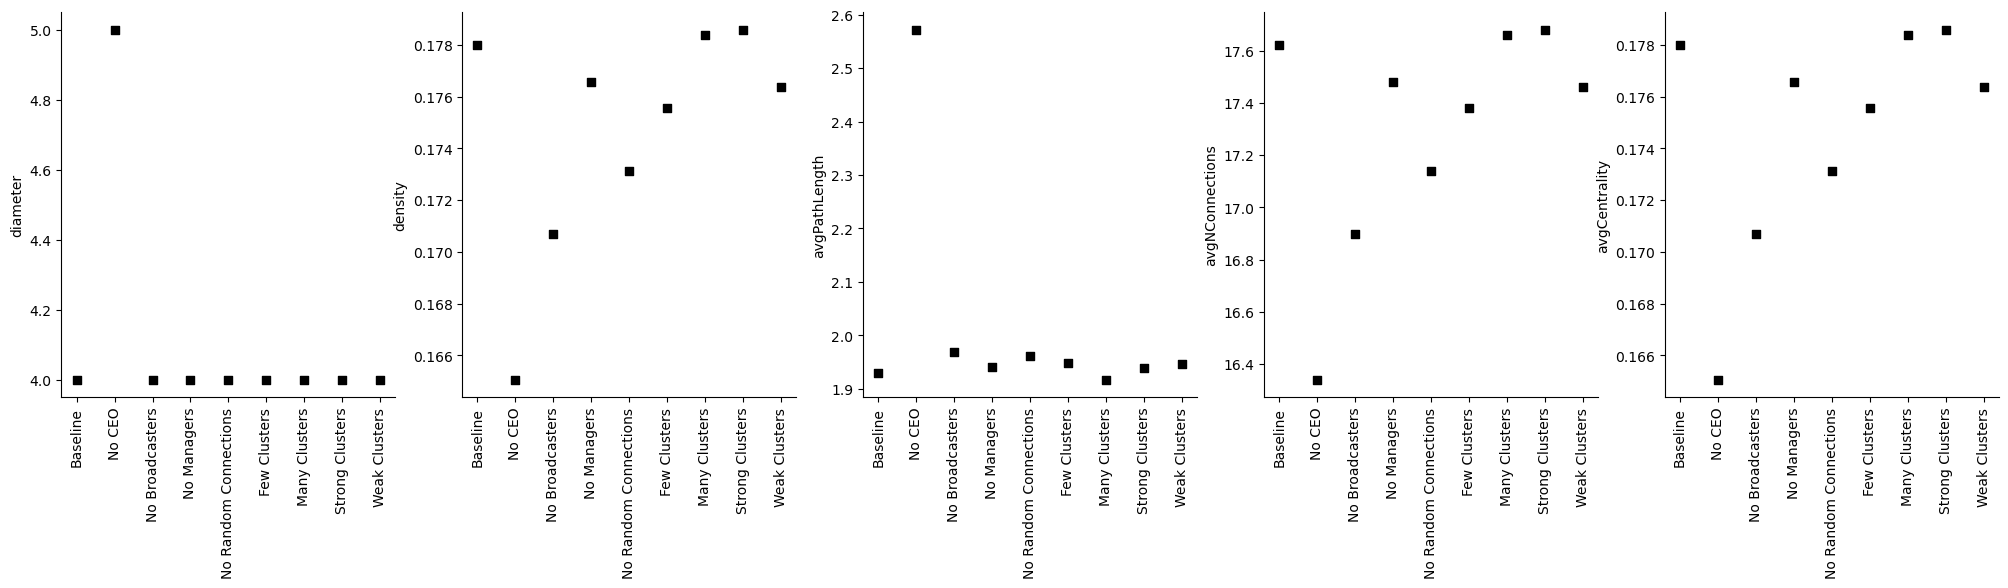

In [22]:
# plot network stats

WIDTH_SIZE=25;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,len(outDict),figsize=(WIDTH_SIZE,HEIGHT_SIZE))

jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=max(socialIndex))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

def rand_jitter(arr):
    stdev = .01;
    return 0 + np.random.randn(len(arr)) * stdev

for mInd,mLabel in enumerate(outDict):
    
    for nInd,nLabel in enumerate(networkLabels):
        axs[mInd].scatter(nInd,networkDicts[nLabel][mLabel],marker='s',color='k')
    
    axs[mInd].set_ylabel(mLabel)
    axs[mInd].set_xticks(range(nNetworks))
    axs[mInd].set_xticklabels(networkLabels,rotation=90)
    
    axs[mInd].spines[['right', 'top']].set_visible(False)

Text(0, 0.5, 'Individual')

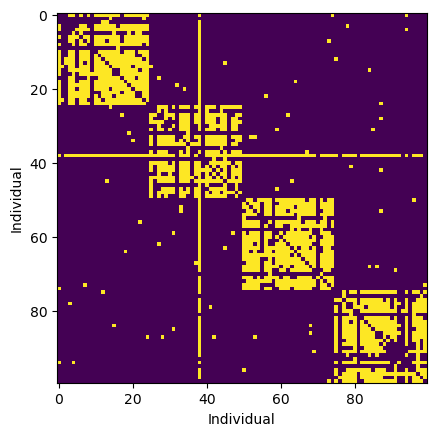

In [23]:
# make data into matrix

dataMat=np.zeros([nNodes,nNodes])
for x in range(len(edge_list)):
    dataMat[edge_list[x][0],edge_list[x][1]]=1
    dataMat[edge_list[x][1],edge_list[x][0]]=1
plt.imshow(dataMat)
plt.xlabel('Individual')
plt.ylabel('Individual')

In [24]:
# louvain clustering
louvain = Louvain()

louvainLabels = louvain.fit_predict(dataMat)
print(louvainLabels)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


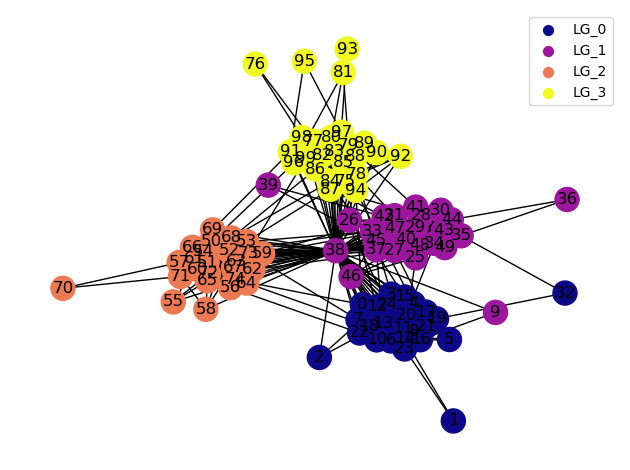

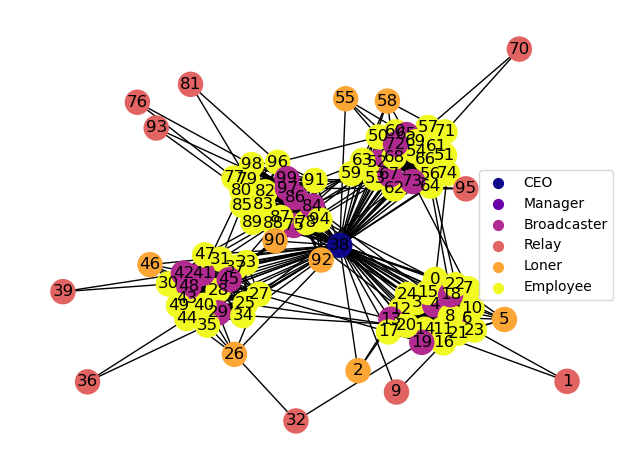

In [25]:
# validate labels
louvainColorLegend=dict()
for i in list(set(louvainLabels)):
    louvainColorLegend["LG_{}".format(i)]=i
# "Max distance between nodes={}".format(diameter)    
visualize_graph_labels(G,louvainLabels,louvainColorLegend)
visualize_graph_labels(G,socialIndex,ColorLegend)


In [26]:
# look at other clustering techniques
# semi-synchronous label propagation method

community_dict=nx.community.label_propagation_communities(G)
propagation_community_labels=np.array(list(list(community_dict)[0]))
prop_community_color_legend=dict()
for i in list(set(propagation_community_labels)):
    prop_community_color_legend["PC_{}".format(i)]=i

/var/folders/0y/_1mrh9h17r10bpj3nm31g1dm0000gn/T/ipykernel_79862/1960887618.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  f.tight_layout()


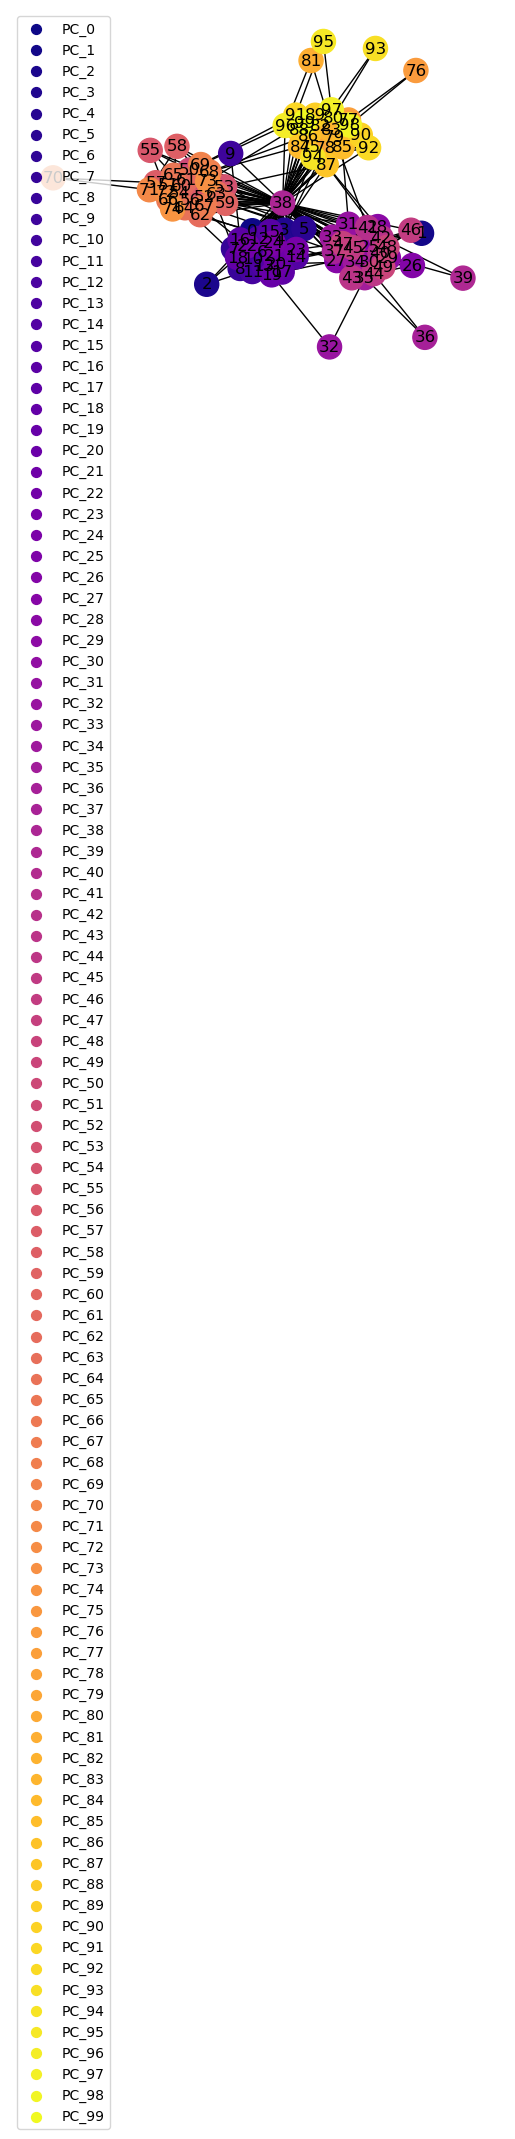

In [27]:
visualize_graph_labels(G,propagation_community_labels,prop_community_color_legend)

In [28]:
# asynchronous fluid communities algorithm
nAFC=3

asyn_fluidc_dict=nx.community.asyn_fluidc(G, 10)
asyn_fluidc_labels=np.array(list(list(asyn_fluidc_dict)[0]))
asyn_fluidc_color_legend=dict()
for i in list(set(asyn_fluidc_labels)):
    asyn_fluidc_color_legend["AFC_{}".format(i)]=i

In [29]:
# visualize_graph_labels(G,asyn_fluidc_labels,asyn_fluidc_color_legend)

asyn_fluidc_labels=np.zeros([1,nNodes])
asyn_fluidc_dict=nx.community.asyn_fluidc(G, nAFC)
asyn_fluidc_color_legend=dict()

for e,com in enumerate(asyn_fluidc_dict):
    asyn_fluidc_color_legend["AFC_{}".format(e)]=e
    for ind in list(com):
        asyn_fluidc_labels[0,ind]=e
asyn_fluidc_labels=asyn_fluidc_labels[0]

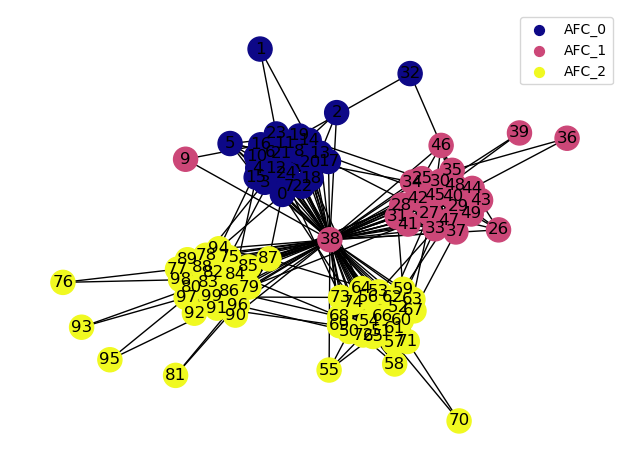

In [30]:
# print(asyn_fluidc_labels[0])
# print(louvainLabels)
visualize_graph_labels(G,asyn_fluidc_labels,asyn_fluidc_color_legend)

In [32]:
# Deliverables

# Assess 'health' of company network using metrics
# - average path length / centrality of different roles 
#   --> compare to baseline/similar company/ideal company network
# - cluster connectivity to identify groups/teams
# - Recommend connections to reduce path length for related teams

# Assess individual employees
# - compare connectivity to employees with similar roles
# - cluster into role group
# - investigate loners/relays
# - recommend connections

In [ ]:
# helpful code

In [ ]:
# are there individual edges that are necessary to link networks?
nx.has_bridges(G)

# Assortativity describes the preference for a network’s nodes to attach to others that are similar in some way.
nx.degree_assortativity_coefficient(G)

In [ ]:
# make karate data into matrix

dataMat=np.zeros([nConnections,nConnections])
for x in range(len(sendNodeList)):
        dataMat[sendNodeList[x],receiveNodeList[x]]=1
        

In [ ]:
# cluster members into groups

nodeConnectionCounts = np.zeros([nNodes,1])
for n in nodeList:
    nodeConnectionCounts[n,0]=cDict[n]
    
print(nodeConnectionCounts)

# nodeConnectionCounts
x = np.random.random(13876)
x.shape
print( x.reshape(-1,1).shape)
print (nodeConnectionCounts.shape)

kmeanModel=KMeans(n_clusters=3).fit(x.reshape(-1,1))
# help(KMeans())